iw, ih: 448 448
(1, 2) (958, 2) (1, 2) [[0.96534421 0.26097998]]
the 0-th was wrong
[]


/home/ubunto/software/miniconda3/envs/3dgs_new/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubunto/software/miniconda3/envs/3dgs_new/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


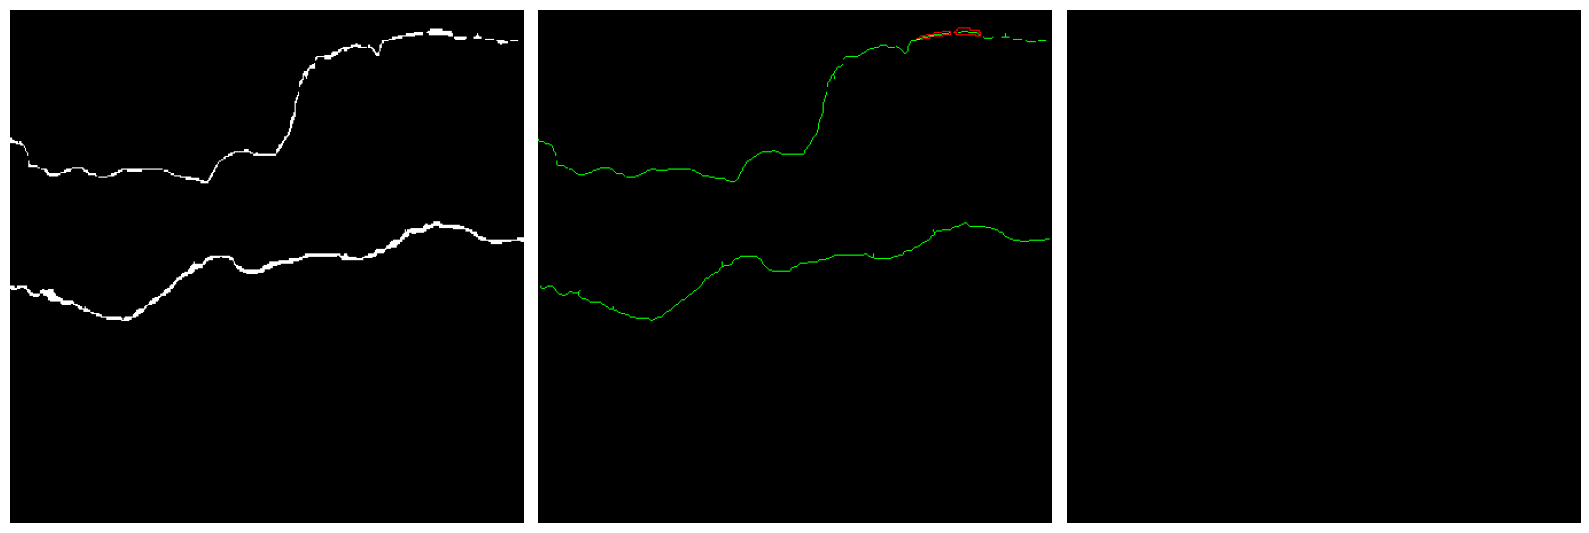

In [11]:
import numpy as np
from skimage import io
from skimage.morphology import medial_axis, skeletonize
from skimage import measure
from skimage import data
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree


def show_2dpoints(pointcluster,s=None,quivers=None,qscale=1):
    # pointcluster should be a list of numpy ndarray
    # This functions would show a list of pint cloud in different colors
    n = len(pointcluster)
    nmax = n
    if quivers is not None:
        nq = len(quivers)
        nmax = max(n,nq)

    colors = ['r','g','b','c','m','y','k','tomato','gold']
    if nmax < 10:
        colors = np.array(colors[0:nmax])
    else: 
        colors = np.random.rand(nmax,3)

    fig = plt.figure(num=1)
    ax = fig.add_subplot(1,1,1)

    if s is None:
        s = np.ones(n)*2

    for i in range(n):
        ax.scatter(pointcluster[i][:,0],pointcluster[i][:,1],s=s[i],c=[colors[i]],alpha=0.6)

    if quivers is not None:
        for i in range(nq):
            ax.quiver(quivers[i][:,0],quivers[i][:,1],quivers[i][:,2],quivers[i][:,3],color=[colors[i]],scale=qscale)

    plt.show()


def SVD(points):
    # 二维，三维均适用
    # 二维直线，三维平面
    pts = points.copy()
    # 奇异值分解
    c = np.mean(pts, axis=0)
    A = pts - c # shift the points
    A = A.T #3*n
    u, s, vh = np.linalg.svd(A, full_matrices=False, compute_uv=True) # A=u*s*vh
    normal = u[:,-1]

    # 法向量归一化
    nlen = np.sqrt(np.dot(normal,normal))
    normal = normal / nlen
    # normal 是主方向的方向向量 与PCA最小特征值对应的特征向量是垂直关系
    # u 每一列是一个方向
    # s 是对应的特征值
    # c >>> 点的中心
    # normal >>> 拟合的方向向量
    return u,s,c,normal


def calcu_dis_from_ctrlpts(ctrlpts):
    if ctrlpts.shape[1]==4:
        return np.sqrt(np.sum((ctrlpts[:,0:2]-ctrlpts[:,2:4])**2,axis=1))
    else:
        return np.sqrt(np.sum((ctrlpts[:,[0,2]]-ctrlpts[:,[3,5]])**2,axis=1))


def estimate_normal_for_pos(pos,points,n):
    # estimate normal vectors at a given point
    pts = np.copy(points)
    tree = KDTree(pts, leaf_size=2)
    idx = tree.query(pos, k=n, return_distance=False, dualtree=False, breadth_first=False)
    #pts = np.concatenate((np.concatenate((pts[0].reshape(1,-1),pts),axis=0),pts[-1].reshape(1,-1)),axis=0)
    normals = []
    for i in range(0,pos.shape[0]):
        pts_for_normals = pts[idx[i,:],:]
        _,_,_,normal = SVD(pts_for_normals)
        normals.append(normal)
    normals = np.array(normals)
    return normals


def estimate_normals(points,n):
    pts = np.copy(points)
    tree = KDTree(pts, leaf_size=2)
    idx = tree.query(pts, k=n, return_distance=False, dualtree=False, breadth_first=False)
    #pts = np.concatenate((np.concatenate((pts[0].reshape(1,-1),pts),axis=0),pts[-1].reshape(1,-1)),axis=0)
    normals = []
    for i in range(0,pts.shape[0]):
        pts_for_normals = pts[idx[i,:],:]
        _,_,_,normal = SVD(pts_for_normals)
        normals.append(normal)
    normals = np.array(normals)
    return normals


def get_crack_ctrlpts(centers,normals,bpoints,hband=5,vband=2):
    # main algorithm to obtain crack width
    cpoints = np.copy(centers)
    cnormals = np.copy(normals)

    xmatrix = np.array([[0,1],[-1,0]])
    cnormalsx = np.dot(xmatrix,cnormals.T).T # the normal of x axis
    N = cpoints.shape[0]

    interp_segm = []
    widths = []
    for i in range(N):
        try:
            ny = cnormals[i]
            nx = cnormalsx[i]
            tform = np.array([nx,ny])
            bpoints_loc = np.dot(tform,bpoints.T).T
            cpoints_loc = np.dot(tform,cpoints.T).T
            ci = cpoints_loc[i]

            bl_ind = (bpoints_loc[:,0]-(ci[0]-hband))*(bpoints_loc[:,0]-ci[0])<0
            br_ind = (bpoints_loc[:,0]-ci[0])*(bpoints_loc[:,0]-(ci[0]+hband))<=0
            bl = bpoints_loc[bl_ind] # left points
            br = bpoints_loc[br_ind] # right points

            blt = bl[bl[:,1]>np.mean(bl[:,1])]
            if np.ptp(blt[:,1])>vband:
                blt = blt[blt[:,1]>np.mean(blt[:,1])]

            blb = bl[bl[:,1]<np.mean(bl[:,1])]
            if np.ptp(blb[:,1])>vband:
                blb = blb[blb[:,1]<np.mean(blb[:,1])]

            brt = br[br[:,1]>np.mean(br[:,1])]
            if np.ptp(brt[:,1])>vband:
                brt = brt[brt[:,1]>np.mean(brt[:,1])]

            brb = br[br[:,1]<np.mean(br[:,1])]
            if np.ptp(brb[:,1])>vband:
                brb = brb[brb[:,1]<np.mean(brb[:,1])]

            #bh = np.vstack((bl,br))
            #bmax = np.max(bh[:,1])
            #bmin = np.min(bh[:,1])

            #blt = bl[bl[:,1]>bmax-vband] # left top points
            #blb = bl[bl[:,1]<bmin+vband] # left bottom points

            #brt = br[br[:,1]>bmax-vband] # right top points
            #brb = br[br[:,1]<bmin+vband] # right bottom points


            t1 = blt[np.argsort(blt[:,0])[-1]]
            t2 = brt[np.argsort(brt[:,0])[0]]

            b1 = blb[np.argsort(blb[:,0])[-1]]
            b2 = brb[np.argsort(brb[:,0])[0]]


            interp1 = (ci[0]-t1[0])*((t2[1]-t1[1])/(t2[0]-t1[0]))+t1[1]
            interp2 = (ci[0]-b1[0])*((b2[1]-b1[1])/(b2[0]-b1[0]))+b1[1]

            if interp1-ci[1]>0 and interp2-ci[1]<0:
                widths.append([i,interp1-ci[1],interp2-ci[1]])

                interps = np.array([[ci[0],interp1],[ci[0],interp2]])

                interps_rec = np.dot(np.linalg.inv(tform),interps.T).T

                #show_2dpoints([bpointsxl_loc1,bpointsxl_loc2,bpointsxr_loc1,bpointsxr_loc2,np.array([ptsl_1,ptsl_2]),np.array([ptsr_1,ptsr_2]),interps,ci.reshape(1,-1)],s=[1,1,1,1,20,20,20,20])
                interps_rec = interps_rec.reshape(1,-1)[0,:]
                interp_segm.append(interps_rec)
        except:
            print("the %d-th was wrong" % i)
            continue
    interp_segm = np.array(interp_segm)
    widths = np.array(widths)
    # check
    # show_2dpoints([np.array([[ci[0],interp1],[ci[0],interp2]]),np.array([t1,t2,b1,b2]),cpoints_loc,bl,br],[10,20,15,2,2])
    return interp_segm, widths


path = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/projection/CFD_044.jpg'


image = io.imread(path, as_gray=True)
iw,ih = image.shape
print('iw, ih:', iw, ih)

blobs  = np.copy(image)
blobs[blobs<128] = 0
blobs[blobs>128] = 1

blobs = blobs.astype(np.uint8)
# Generate the data
#blobs = data.binary_blobs(200, blob_size_fraction=.2,
                          #volume_fraction=.35, seed=1)
# using scikit-image
## Compute the medial axis (skeleton) and the distance transform
#skel, distance = medial_axis(blobs, return_distance=True)
## Distance to the background for pixels of the skeleton
#dist_on_skel = distance * skel

# Compare with other skeletonization algorithms
skeleton = skeletonize(blobs)
#skeleton_lee = skeletonize(blobs, method='lee')
x, y = np.where(skeleton>0)
centers = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))
normals = estimate_normals(centers,3)

# search contours of the crack
contours = measure.find_contours(blobs, 0.8)

bl = contours[0]
br = contours[1]

bpoints = np.vstack((bl,br))

#interp_segm, widths = get_crack_ctrlpts(centers,normals,bpoints,hband=2,vband=2)


bpixel = np.zeros((iw,ih,3),dtype=np.uint8)
bpoints = bpoints.astype(int)
bpixel[bpoints[:,0],bpoints[:,1],0] = 255

skeleton_pixel = np.zeros((iw,ih,3),dtype=np.uint8)
skeleton_pixel[skeleton,1] = 255

bpixel_and_skeleton = np.copy(bpixel)
bpixel_and_skeleton[skeleton,1] = 255


fig, axes = plt.subplots(1,3, figsize=(16, 16))
ax = axes.ravel()

ax[0].imshow(blobs, cmap=plt.cm.gray)
ax[0].axis('off')


ax[1].imshow(bpixel_and_skeleton)
#for contour in contours:
#    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

#for i in range(interp_segm.shape[0]):
#    ax[1].plot([interp_segm[i,1],interp_segm[i,3]],[interp_segm[i,0],interp_segm[i,2]],'-b')

#ax[1].set_title('medial_axis')
ax[1].axis('off')


# ================ small window ==================
pos = np.array([200, 100]).reshape(1,-1) # input (x,y) where need to calculate crack width
# pos = np.array([142, 178]).reshape(1,-1)

posn = estimate_normal_for_pos(pos,centers,3)
print(pos.shape, centers.shape, posn.shape, posn)

interps, widths2 = get_crack_ctrlpts(pos,posn,bpoints,hband=5,vband=5)


sx = pos[0,0] - 20
sy = pos[0,1] - 20

ax[2].imshow(bpixel_and_skeleton)

for i in range(interps.shape[0]):
    ax[2].plot([interps[i,1],interps[i,3]],[interps[i,0],interps[i,2]],c='c',ls='-',lw=5,marker='o',ms=8,mec='c',mfc='c')

ax[2].set_ylim(sx,sx+40)
ax[2].set_xlim(sy,sy+40)

#ax[2].set_title('skeletonize')
ax[2].axis('off')

print(interps)

fig.tight_layout()

plt.show()

####### np.unique(image) ####### [False  True]
(448, 448)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
########### skeleton.shape ########### (448, 448) [0 1] uint8
centers.shape (950, 2)
len(contours) 39
bpoints.shape (2642, 2)
the 15-th was wrong
the 24-th was wrong
the 32-th was wrong
the 34-th was wrong
the 35-th was wrong
the 40-th was wrong
the 47-th was wrong
the 57-th was wrong
the 58-th was wrong
the 59-th was wrong
the 60-th was wrong
the 62-th was wrong
the 63-th was wrong
the 64-th was wrong
the 65-th was wrong
the 66-th was wrong
the 67-th was wrong
the 68-th was wrong
the 69-th was wrong
the 70-th was wrong
the 71-th was wrong
the 73-th was wrong
the 74-th was wrong
the 75-th was wrong
the 76-th was wrong
the 77-th was wrong
the 78-th was wrong
the 79-th was wrong
the 80-th was wrong
the 81-th was wrong
the 82-th was wrong
the 83-th was wrong
the 90-th was wrong
the 91-th was wrong
the 92-th was wr

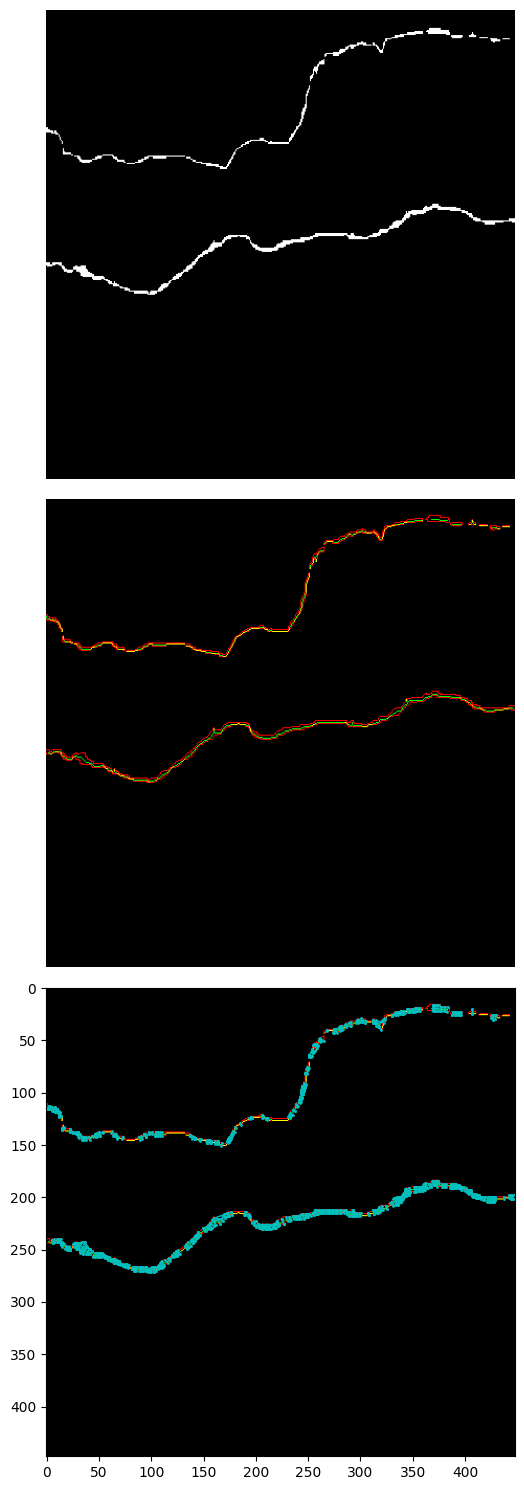

In [54]:
import numpy as np
from skimage import io
from skimage.morphology import medial_axis, skeletonize
from skimage import measure
from skimage import data
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from PIL import Image


def show_2dpoints(pointcluster,s=None,quivers=None,qscale=1):
    # pointcluster should be a list of numpy ndarray
    # This functions would show a list of pint cloud in different colors
    n = len(pointcluster)
    nmax = n
    if quivers is not None:
        nq = len(quivers)
        nmax = max(n,nq)
    
    colors = ['r','g','b','c','m','y','k','tomato','gold']
    if nmax < 10:
        colors = np.array(colors[0:nmax])
    else: 
        colors = np.random.rand(nmax,3)

    fig = plt.figure(num=1)
    ax = fig.add_subplot(1,1,1)

    if s is None:
        s = np.ones(n)*2

    for i in range(n):
        ax.scatter(pointcluster[i][:,0],pointcluster[i][:,1],s=s[i],c=[colors[i]],alpha=0.6)

    if quivers is not None:
        for i in range(nq):
            ax.quiver(quivers[i][:,0],quivers[i][:,1],quivers[i][:,2],quivers[i][:,3],color=[colors[i]],scale=qscale)

    plt.show()


def SVD(points):
    # 二维，三维均适用
    # 二维直线，三维平面
    pts = points.copy()
    # 奇异值分解
    c = np.mean(pts, axis=0)
    A = pts - c # shift the points
    A = A.T #3*n
    u, s, vh = np.linalg.svd(A, full_matrices=False, compute_uv=True) # A=u*s*vh
    normal = u[:,-1]

    # 法向量归一化
    nlen = np.sqrt(np.dot(normal,normal))
    normal = normal / nlen
    # normal 是主方向的方向向量 与PCA最小特征值对应的特征向量是垂直关系
    # u 每一列是一个方向
    # s 是对应的特征值
    # c >>> 点的中心
    # normal >>> 拟合的方向向量
    return u,s,c,normal


def calcu_dis_from_ctrlpts(ctrlpts):
    if ctrlpts.shape[1]==4:
        return np.sqrt(np.sum((ctrlpts[:,0:2]-ctrlpts[:,2:4])**2,axis=1))
    else:
        return np.sqrt(np.sum((ctrlpts[:,[0,2]]-ctrlpts[:,[3,5]])**2,axis=1))


def estimate_normal_for_pos(pos,points,n):
    """
    计算pos处的法向量.
    
    Input：
    ------
    pos: nx2 ndarray 需要计算法向量的位置.
    points: 骨架线的点集
    n: 用到的近邻点的个数
    
    Output：
    ------
    normals: nx2 ndarray 在pos位置处的法向量.
    """
    
    # estimate normal vectors at a given point
    pts = np.copy(points)
    tree = KDTree(pts, leaf_size=2)
    idx = tree.query(pos, k=n, return_distance=False, dualtree=False, breadth_first=False)
    #pts = np.concatenate((np.concatenate((pts[0].reshape(1,-1),pts),axis=0),pts[-1].reshape(1,-1)),axis=0)
    normals = []
    for i in range(0,pos.shape[0]):
        pts_for_normals = pts[idx[i,:],:]
        _,_,_,normal = SVD(pts_for_normals)
        normals.append(normal)
    normals = np.array(normals)
    return normals


def estimate_normals(points,n):
    """
    计算points表示的曲线上的每一个点法向量.
    等同于 estimate_normal_for_pos(points,points,n)

    Input：
    ------
    points: nx2 ndarray 曲线点集.
    n: 用到的近邻点的个数
    
    Output：
    ------
    normals: nx2 ndarray 在points曲线上的每一处的法向量.
    """
    
    pts = np.copy(points)
    tree = KDTree(pts, leaf_size=2)
    idx = tree.query(pts, k=n, return_distance=False, dualtree=False, breadth_first=False)
    #pts = np.concatenate((np.concatenate((pts[0].reshape(1,-1),pts),axis=0),pts[-1].reshape(1,-1)),axis=0)
    normals = []
    for i in range(0,pts.shape[0]):
        pts_for_normals = pts[idx[i,:],:]
        _,_,_,normal = SVD(pts_for_normals)
        normals.append(normal)
    normals = np.array(normals)
    return normals

def get_crack_ctrlpts(centers,normals,bpoints,hband=5,vband=2,est_width=0):
    # main algorithm to obtain crack width
    cpoints = np.copy(centers)
    cnormals = np.copy(normals)

    xmatrix = np.array([[0,1],[-1,0]])
    cnormalsx = np.dot(xmatrix,cnormals.T).T # the normal of x axis
    N = cpoints.shape[0]

    bpixel_and_skeleton = []
    widths = []
    for i in range(N):
        try:
            ny = cnormals[i]
            nx = cnormalsx[i]
            tform = np.array([nx,ny])
            bpoints_loc = np.dot(tform,bpoints.T).T
            cpoints_loc = np.dot(tform,cpoints.T).T
            ci = cpoints_loc[i]

            bl_ind = (bpoints_loc[:,0]-(ci[0]-hband))*(bpoints_loc[:,0]-ci[0])<0
            br_ind = (bpoints_loc[:,0]-ci[0])*(bpoints_loc[:,0]-(ci[0]+hband))<=0
            bl = bpoints_loc[bl_ind] # left points
            br = bpoints_loc[br_ind] # right points

            if est_width>0:
                # 下面的数值 est_width 是预估计的裂缝宽度
                half_est_width = est_width / 2
                blt = bl[(bl[:,1]-(ci[1]+half_est_width))*(bl[:,1]-ci[1])<0]
                blb = bl[(bl[:,1]-(ci[1]-half_est_width))*(bl[:,1]-ci[1])<0]
                brt = br[(br[:,1]-(ci[1]+half_est_width))*(br[:,1]-ci[1])<0]
                brb = br[(br[:,1]-(ci[1]-half_est_width))*(br[:,1]-ci[1])<0]
            else:
                blt = bl[bl[:,1]>np.mean(bl[:,1])]
                if np.ptp(blt[:,1])>vband:
                    blt = blt[blt[:,1]>np.mean(blt[:,1])]

                blb = bl[bl[:,1]<np.mean(bl[:,1])]
                if np.ptp(blb[:,1])>vband:
                    blb = blb[blb[:,1]<np.mean(blb[:,1])]

                brt = br[br[:,1]>np.mean(br[:,1])]
                if np.ptp(brt[:,1])>vband:
                    brt = brt[brt[:,1]>np.mean(brt[:,1])]

                brb = br[br[:,1]<np.mean(br[:,1])]
                if np.ptp(brb[:,1])>vband:
                    brb = brb[brb[:,1]<np.mean(brb[:,1])]

                # blt = bl[bl[:,1]>np.mean(bl[:,1])]
                # if np.ptp(blt[:,1])>vband:
                #    blt = blt[blt[:,1]<ci[1]+50]
                #    #blt = blt[blt[:,1]>np.mean(blt[:,1])] （外侧）
                #    #blt = blt[blt[:,1]<(np.max(blt[:,1])-0.5*np.ptp(blt[:,1]))] （内侧）

                # blb = bl[bl[:,1]<np.mean(bl[:,1])]
                # if np.ptp(blb[:,1])>vband:
                #    blb = blb[blb[:,1]>ci[1]-50]
                #    #blb = blb[blb[:,1]<np.mean(blb[:,1])]
                #    #blb = blb[blb[:,1]>(np.min(blb[:,1])+0.5*np.ptp(blb[:,1]))]

                # brt = br[br[:,1]>np.mean(br[:,1])]
                # if np.ptp(brt[:,1])>vband:
                #    brt = brt[brt[:,1]<ci[1]+50]
                #    #brt = brt[brt[:,1]>np.mean(brt[:,1])]
                #    #brt = brt[brt[:,1]<(np.max(brt[:,1])-0.5*np.ptp(brt[:,1]))]

                # brb = br[br[:,1]<np.mean(br[:,1])]
                # if np.ptp(brb[:,1])>vband:
                #    brb = brb[brb[:,1]>ci[1]-50]
                #    # brb = brb[brb[:,1]<np.mean(brb[:,1])]
                #    # brb = brb[brb[:,1]>(np.min(brb[:,1])+0.5*np.ptp(brb[:,1]))]

            #bh = np.vstack((bl,br))
            #bmax = np.max(bh[:,1])
            #bmin = np.min(bh[:,1])

            #blt = bl[bl[:,1]>bmax-vband] # left top points
            #blb = bl[bl[:,1]<bmin+vband] # left bottom points

            #brt = br[br[:,1]>bmax-vband] # right top points
            #brb = br[br[:,1]<bmin+vband] # right bottom points


            t1 = blt[np.argsort(blt[:,0])[-1]]
            t2 = brt[np.argsort(brt[:,0])[0]]

            b1 = blb[np.argsort(blb[:,0])[-1]]
            b2 = brb[np.argsort(brb[:,0])[0]]


            interp1 = (ci[0]-t1[0])*((t2[1]-t1[1])/(t2[0]-t1[0]))+t1[1]
            interp2 = (ci[0]-b1[0])*((b2[1]-b1[1])/(b2[0]-b1[0]))+b1[1]

            if interp1-ci[1]>0 and interp2-ci[1]<0:
                widths.append([i,interp1-ci[1],interp2-ci[1]])

                interps = np.array([[ci[0],interp1],[ci[0],interp2]])

                interps_rec = np.dot(np.linalg.inv(tform),interps.T).T

                #show_2dpoints([bpointsxl_loc1,bpointsxl_loc2,bpointsxr_loc1,bpointsxr_loc2,np.array([ptsl_1,ptsl_2]),np.array([ptsr_1,ptsr_2]),interps,ci.reshape(1,-1)],s=[1,1,1,1,20,20,20,20])
                interps_rec = interps_rec.reshape(1,-1)[0,:]
                bpixel_and_skeleton.append(interps_rec)
        except:
            print("the %d-th was wrong" % i)
            continue
    bpixel_and_skeleton = np.array(bpixel_and_skeleton)
    widths = np.array(widths)
    # check
    # show_2dpoints([np.array([[ci[0],interp1],[ci[0],interp2]]),np.array([t1,t2,b1,b2]),cpoints_loc,bl,br],[10,20,15,2,2])
    return bpixel_and_skeleton, widths

######################################################
if __name__ == '__main__':
    path = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/projection/CFD_044.jpg'
    # path = '/home/ubunto/图片/2025-06-13_15-51.png'


    # image = io.imread(path, as_gray=True)
    # image_pil = Image.open(path).convert('1')
    # image = np.array(image_pil)

    # 用此方法读取图片，可以自动判断图片的模式，并将其转化为0-1的灰度图
    def judge_image_mode(path):
        img_pil = Image.open(path)
        img = np.array(img_pil)

        # 根据读取的mask的信息，判断后续操作（有的mask数值取值范围为0-1，有的取值范围为0-255）
        if np.max(img) == 255:
            img_pil = Image.open(path).convert('1')
            img = np.array(img_pil)
        else:
            img_pil = Image.open(path)
            img = np.array(img_pil)
        return img_pil, img

    image_pil, image = judge_image_mode(path)
    print('####### np.unique(image) #######', np.unique(image))
    # image中不为1的地方为背景，为1的地方为前景
    # image[image!= True] = 0
    # image[image == True] = 255
    image[image!= True] = 0
    image[image == True] = 255
    
    img_pil_new = Image.fromarray(image)
    image_pil = img_pil_new.convert('1')
    image = np.array(image_pil)
    print(image.shape)
    iw,ih = image.shape

    blobs  = np.copy(image)
    # blobs[blobs<128] = 0
    # blobs[blobs>128] = 1

    blobs = blobs.astype(np.uint8)
    # Generate the data
    #blobs = data.binary_blobs(200, blob_size_fraction=.2,
                            #volume_fraction=.35, seed=1)
    # using scikit-image
    ## Compute the medial axis (skeleton) and the distance transform
    #skel, distance = medial_axis(blobs, return_distance=True)
    ## Distance to the background for pixels of the skeleton
    #dist_on_skel = distance * skel

    # Compare with other skeletonization algorithms
    print(blobs)
    skeleton = skeletonize(blobs, method='lee')
    # skeleton = skeletonize(blobs)
    print("########### skeleton.shape ###########", skeleton.shape, np.unique(skeleton), skeleton.dtype)
    if skeleton.dtype == np.uint8:
        skeleton = skeleton.astype(np.bool_)

    #skeleton_lee = skeletonize(blobs, method='lee')
    x, y = np.where(skeleton>0)
    centers = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))
    print('centers.shape', centers.shape)

    normals = estimate_normals(centers, 9) # 这个用于估计法向量的KNN

    # search contours of the crack
    contours = measure.find_contours(blobs, 0.8)
    print('len(contours)', len(contours))
    # print(contours[0].shape, contours[1].shape) 
    # bl = contours[0]
    # br = contours[1]

    # bpoints = np.vstack((bl,br))
    bpoints = np.concatenate(contours,axis=0)
    print('bpoints.shape', bpoints.shape)

    #bpixel_and_skeleton, widths = get_crack_ctrlpts(centers,normals,bpoints,hband=2,vband=2)


    bpixel = np.zeros((iw,ih,3),dtype=np.uint8)
    bpoints = bpoints.astype(np.int64)
    bpixel[bpoints[:,0],bpoints[:,1],0] = 255

    skeleton_pixel = np.zeros((iw,ih,3),dtype=np.uint8)
    skeleton_pixel[skeleton,1] = 255

    bpixel_and_skeleton = np.copy(bpixel)
    bpixel_and_skeleton[skeleton,1] = 255


    fig, axes = plt.subplots(3,1, figsize=(60, 15))
    ax = axes.ravel()

    ax[0].imshow(blobs, cmap=plt.cm.gray)
    ax[0].axis('off')


    ax[1].imshow(bpixel_and_skeleton)
    #for contour in contours:
    #    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

    # for n, contour in enumerate(contours):
    #     ax[1].plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')
    #ax[1].set_title('medial_axis')
    ax[1].axis('off')


    ax[2].imshow(bpixel_and_skeleton)
    interps, widths = get_crack_ctrlpts(centers, normals, bpoints, hband=2, vband=2, est_width=30)
    print('interps.shape, widths.shape', interps.shape, widths.shape)

    # interps_show = interps[np.random.choice(interps.shape[0], 120, replace=False),:] # 由于太多，这里随机采样120个测量位置，进行显示
    interps_show = interps[np.random.choice(interps.shape[0], interps.shape[0]),:] # 由于太多，这里随机采样120个测量位置，进行显示
    for i in range(interps_show.shape[0]):
        ax[2].plot([interps_show[i,1],interps_show[i,3]],[interps_show[i,0],interps_show[i,2]],c='c', ls='-', lw=1, marker='o',ms=1,mec='c',mfc='c')



    ## ================ small window ==================
    #pos = np.array([191, 291]).reshape(1,-1) # input (x,y) where need to calculate crack width
    ## pos = np.array([142, 178]).reshape(1,-1)

    #posn = estimate_normal_for_pos(pos,centers,3)

    #interps, widths2 = get_crack_ctrlpts(pos,posn,bpoints,hband=1.5,vband=2)


    #sx = pos[0,0] - 20
    #sy = pos[0,1] - 20

    #ax[2].imshow(bpixel_and_skeleton)

    #for i in range(interps.shape[0]):
    #    ax[2].plot([interps[i,1],interps[i,3]],[interps[i,0],interps[i,2]],c='c',ls='-',lw=5,marker='o',ms=8,mec='c',mfc='c')

    #ax[2].set_ylim(sx,sx+40)
    #ax[2].set_xlim(sy,sy+40)

    ##ax[2].set_title('skeletonize')
    #ax[2].axis('off')

    #print(interps)

    fig.tight_layout()
    fig.savefig('crack_width_estimation.png', dpi=300)

    plt.show()



####### np.unique(image) ####### [False  True]
(260, 401)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
########### skeleton.shape ########### (260, 401) [False  True] bool
centers.shape (485, 2)
len(contours) 2
bpoints.shape (1327, 2)
the 0-th was wrong
the 1-th was wrong
the 2-th was wrong
the 3-th was wrong
the 4-th was wrong
the 5-th was wrong
the 6-th was wrong
the 7-th was wrong
the 8-th was wrong
the 9-th was wrong
the 13-th was wrong
the 14-th was wrong
the 19-th was wrong
the 27-th was wrong
the 28-th was wrong
the 32-th was wrong
the 33-th was wrong
the 35-th was wrong
the 36-th was wrong
the 137-th was wrong
the 140-th was wrong
the 141-th was wrong
the 144-th was wrong
the 147-th was wrong
the 150-th was wrong
the 278-th was wrong
the 279-th was wrong
the 280-th was wrong
the 281-th was wrong
the 283-th was wrong
the 284-th was wrong
the 285-th was wrong
the 298-th was wrong
the 299-th was wrong
the 3

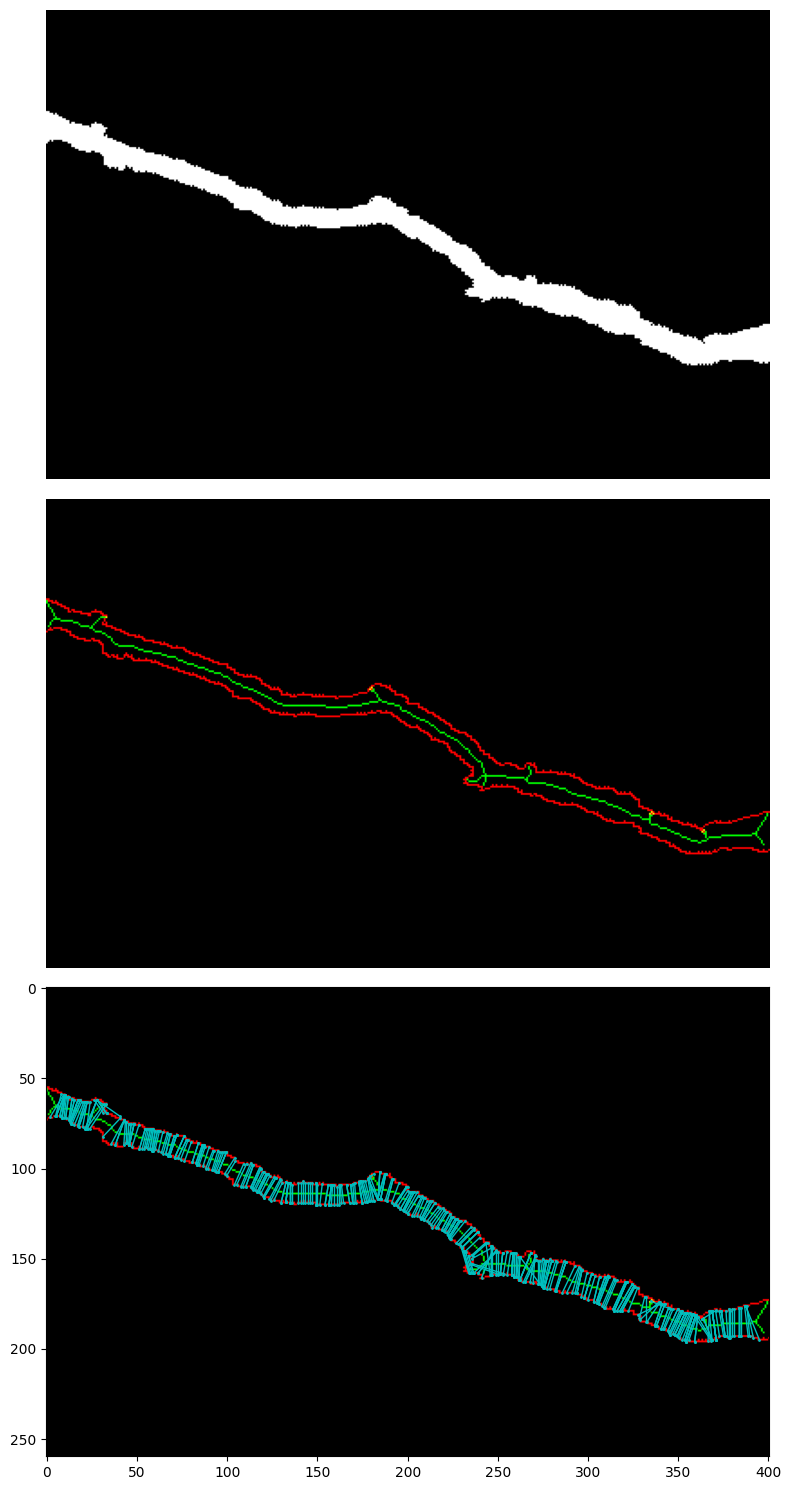

In [57]:
import numpy as np
from skimage import io
from skimage.morphology import medial_axis, skeletonize
from skimage import measure
from skimage import data
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from PIL import Image


def show_2dpoints(pointcluster,s=None,quivers=None,qscale=1):
    # pointcluster should be a list of numpy ndarray
    # This functions would show a list of pint cloud in different colors
    n = len(pointcluster)
    nmax = n
    if quivers is not None:
        nq = len(quivers)
        nmax = max(n,nq)
    
    colors = ['r','g','b','c','m','y','k','tomato','gold']
    if nmax < 10:
        colors = np.array(colors[0:nmax])
    else: 
        colors = np.random.rand(nmax,3)

    fig = plt.figure(num=1)
    ax = fig.add_subplot(1,1,1)

    if s is None:
        s = np.ones(n)*2

    for i in range(n):
        ax.scatter(pointcluster[i][:,0],pointcluster[i][:,1],s=s[i],c=[colors[i]],alpha=0.6)

    if quivers is not None:
        for i in range(nq):
            ax.quiver(quivers[i][:,0],quivers[i][:,1],quivers[i][:,2],quivers[i][:,3],color=[colors[i]],scale=qscale)

    plt.show()


def SVD(points):
    # 二维，三维均适用
    # 二维直线，三维平面
    pts = points.copy()
    # 奇异值分解
    c = np.mean(pts, axis=0)
    A = pts - c # shift the points
    A = A.T #3*n
    u, s, vh = np.linalg.svd(A, full_matrices=False, compute_uv=True) # A=u*s*vh
    normal = u[:,-1]

    # 法向量归一化
    nlen = np.sqrt(np.dot(normal,normal))
    normal = normal / nlen
    # normal 是主方向的方向向量 与PCA最小特征值对应的特征向量是垂直关系
    # u 每一列是一个方向
    # s 是对应的特征值
    # c >>> 点的中心
    # normal >>> 拟合的方向向量
    return u,s,c,normal


def calcu_dis_from_ctrlpts(ctrlpts):
    if ctrlpts.shape[1]==4:
        return np.sqrt(np.sum((ctrlpts[:,0:2]-ctrlpts[:,2:4])**2,axis=1))
    else:
        return np.sqrt(np.sum((ctrlpts[:,[0,2]]-ctrlpts[:,[3,5]])**2,axis=1))


def estimate_normal_for_pos(pos,points,n):
    """
    计算pos处的法向量.
    
    Input：
    ------
    pos: nx2 ndarray 需要计算法向量的位置.
    points: 骨架线的点集
    n: 用到的近邻点的个数
    
    Output：
    ------
    normals: nx2 ndarray 在pos位置处的法向量.
    """
    
    # estimate normal vectors at a given point
    pts = np.copy(points)
    tree = KDTree(pts, leaf_size=2)
    idx = tree.query(pos, k=n, return_distance=False, dualtree=False, breadth_first=False)
    #pts = np.concatenate((np.concatenate((pts[0].reshape(1,-1),pts),axis=0),pts[-1].reshape(1,-1)),axis=0)
    normals = []
    for i in range(0,pos.shape[0]):
        pts_for_normals = pts[idx[i,:],:]
        _,_,_,normal = SVD(pts_for_normals)
        normals.append(normal)
    normals = np.array(normals)
    return normals


def estimate_normals(points,n):
    """
    计算points表示的曲线上的每一个点法向量.
    等同于 estimate_normal_for_pos(points,points,n)

    Input：
    ------
    points: nx2 ndarray 曲线点集.
    n: 用到的近邻点的个数
    
    Output：
    ------
    normals: nx2 ndarray 在points曲线上的每一处的法向量.
    """
    
    pts = np.copy(points)
    tree = KDTree(pts, leaf_size=2)
    idx = tree.query(pts, k=n, return_distance=False, dualtree=False, breadth_first=False)
    #pts = np.concatenate((np.concatenate((pts[0].reshape(1,-1),pts),axis=0),pts[-1].reshape(1,-1)),axis=0)
    normals = []
    for i in range(0,pts.shape[0]):
        pts_for_normals = pts[idx[i,:],:]
        _,_,_,normal = SVD(pts_for_normals)
        normals.append(normal)
    normals = np.array(normals)
    return normals

def get_crack_ctrlpts(centers,normals,bpoints,hband=5,vband=2,est_width=0):
    # main algorithm to obtain crack width
    cpoints = np.copy(centers)
    cnormals = np.copy(normals)

    xmatrix = np.array([[0,1],[-1,0]])
    cnormalsx = np.dot(xmatrix,cnormals.T).T # the normal of x axis
    N = cpoints.shape[0]

    bpixel_and_skeleton = []
    widths = []
    for i in range(N):
        try:
            ny = cnormals[i]
            nx = cnormalsx[i]
            tform = np.array([nx,ny])
            bpoints_loc = np.dot(tform,bpoints.T).T
            cpoints_loc = np.dot(tform,cpoints.T).T
            ci = cpoints_loc[i]

            bl_ind = (bpoints_loc[:,0]-(ci[0]-hband))*(bpoints_loc[:,0]-ci[0])<0
            br_ind = (bpoints_loc[:,0]-ci[0])*(bpoints_loc[:,0]-(ci[0]+hband))<=0
            bl = bpoints_loc[bl_ind] # left points
            br = bpoints_loc[br_ind] # right points

            if est_width>0:
                # 下面的数值 est_width 是预估计的裂缝宽度
                half_est_width = est_width / 2
                blt = bl[(bl[:,1]-(ci[1]+half_est_width))*(bl[:,1]-ci[1])<0]
                blb = bl[(bl[:,1]-(ci[1]-half_est_width))*(bl[:,1]-ci[1])<0]
                brt = br[(br[:,1]-(ci[1]+half_est_width))*(br[:,1]-ci[1])<0]
                brb = br[(br[:,1]-(ci[1]-half_est_width))*(br[:,1]-ci[1])<0]
            else:
                blt = bl[bl[:,1]>np.mean(bl[:,1])]
                if np.ptp(blt[:,1])>vband:
                    blt = blt[blt[:,1]>np.mean(blt[:,1])]

                blb = bl[bl[:,1]<np.mean(bl[:,1])]
                if np.ptp(blb[:,1])>vband:
                    blb = blb[blb[:,1]<np.mean(blb[:,1])]

                brt = br[br[:,1]>np.mean(br[:,1])]
                if np.ptp(brt[:,1])>vband:
                    brt = brt[brt[:,1]>np.mean(brt[:,1])]

                brb = br[br[:,1]<np.mean(br[:,1])]
                if np.ptp(brb[:,1])>vband:
                    brb = brb[brb[:,1]<np.mean(brb[:,1])]

                # blt = bl[bl[:,1]>np.mean(bl[:,1])]
                # if np.ptp(blt[:,1])>vband:
                #    blt = blt[blt[:,1]<ci[1]+50]
                #    #blt = blt[blt[:,1]>np.mean(blt[:,1])] （外侧）
                #    #blt = blt[blt[:,1]<(np.max(blt[:,1])-0.5*np.ptp(blt[:,1]))] （内侧）

                # blb = bl[bl[:,1]<np.mean(bl[:,1])]
                # if np.ptp(blb[:,1])>vband:
                #    blb = blb[blb[:,1]>ci[1]-50]
                #    #blb = blb[blb[:,1]<np.mean(blb[:,1])]
                #    #blb = blb[blb[:,1]>(np.min(blb[:,1])+0.5*np.ptp(blb[:,1]))]

                # brt = br[br[:,1]>np.mean(br[:,1])]
                # if np.ptp(brt[:,1])>vband:
                #    brt = brt[brt[:,1]<ci[1]+50]
                #    #brt = brt[brt[:,1]>np.mean(brt[:,1])]
                #    #brt = brt[brt[:,1]<(np.max(brt[:,1])-0.5*np.ptp(brt[:,1]))]

                # brb = br[br[:,1]<np.mean(br[:,1])]
                # if np.ptp(brb[:,1])>vband:
                #    brb = brb[brb[:,1]>ci[1]-50]
                #    # brb = brb[brb[:,1]<np.mean(brb[:,1])]
                #    # brb = brb[brb[:,1]>(np.min(brb[:,1])+0.5*np.ptp(brb[:,1]))]

            #bh = np.vstack((bl,br))
            #bmax = np.max(bh[:,1])
            #bmin = np.min(bh[:,1])

            #blt = bl[bl[:,1]>bmax-vband] # left top points
            #blb = bl[bl[:,1]<bmin+vband] # left bottom points

            #brt = br[br[:,1]>bmax-vband] # right top points
            #brb = br[br[:,1]<bmin+vband] # right bottom points


            t1 = blt[np.argsort(blt[:,0])[-1]]
            t2 = brt[np.argsort(brt[:,0])[0]]

            b1 = blb[np.argsort(blb[:,0])[-1]]
            b2 = brb[np.argsort(brb[:,0])[0]]


            interp1 = (ci[0]-t1[0])*((t2[1]-t1[1])/(t2[0]-t1[0]))+t1[1]
            interp2 = (ci[0]-b1[0])*((b2[1]-b1[1])/(b2[0]-b1[0]))+b1[1]

            if interp1-ci[1]>0 and interp2-ci[1]<0:
                widths.append([i,interp1-ci[1],interp2-ci[1]])

                interps = np.array([[ci[0],interp1],[ci[0],interp2]])

                interps_rec = np.dot(np.linalg.inv(tform),interps.T).T

                #show_2dpoints([bpointsxl_loc1,bpointsxl_loc2,bpointsxr_loc1,bpointsxr_loc2,np.array([ptsl_1,ptsl_2]),np.array([ptsr_1,ptsr_2]),interps,ci.reshape(1,-1)],s=[1,1,1,1,20,20,20,20])
                interps_rec = interps_rec.reshape(1,-1)[0,:]
                bpixel_and_skeleton.append(interps_rec)
        except:
            print("the %d-th was wrong" % i)
            continue
    bpixel_and_skeleton = np.array(bpixel_and_skeleton)
    widths = np.array(widths)
    # check
    # show_2dpoints([np.array([[ci[0],interp1],[ci[0],interp2]]),np.array([t1,t2,b1,b2]),cpoints_loc,bl,br],[10,20,15,2,2])
    return bpixel_and_skeleton, widths

######################################################
if __name__ == '__main__':
    # path = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/projection/CFD_044.jpg'
    path = '/home/ubunto/图片/2025-06-13_15-51.png'


    # image = io.imread(path, as_gray=True)
    # image_pil = Image.open(path).convert('1')
    # image = np.array(image_pil)

    # 用此方法读取图片，可以自动判断图片的模式，并将其转化为0-1的灰度图
    def judge_image_mode(path):
        img_pil = Image.open(path)
        img = np.array(img_pil)

        # 根据读取的mask的信息，判断后续操作（有的mask数值取值范围为0-1，有的取值范围为0-255）
        if np.max(img) == 255:
            img_pil = Image.open(path).convert('1')
            img = np.array(img_pil)
        else:
            img_pil = Image.open(path)
            img = np.array(img_pil)
        return img_pil, img

    image_pil, image = judge_image_mode(path)
    print('####### np.unique(image) #######', np.unique(image))
    # image中不为1的地方为背景，为1的地方为前景
    # image[image!= True] = 0
    # image[image == True] = 255
    image[image!= True] = 0
    image[image == True] = 255
    
    img_pil_new = Image.fromarray(image)
    image_pil = img_pil_new.convert('1')
    image = np.array(image_pil)
    print(image.shape)
    iw,ih = image.shape

    blobs  = np.copy(image)
    # blobs[blobs<128] = 0
    # blobs[blobs>128] = 1

    blobs = blobs.astype(np.uint8)
    # Generate the data
    #blobs = data.binary_blobs(200, blob_size_fraction=.2,
                            #volume_fraction=.35, seed=1)
    # using scikit-image
    ## Compute the medial axis (skeleton) and the distance transform
    #skel, distance = medial_axis(blobs, return_distance=True)
    ## Distance to the background for pixels of the skeleton
    #dist_on_skel = distance * skel

    # Compare with other skeletonization algorithms
    print(blobs)
    # skeleton = skeletonize(blobs, method='lee')
    skeleton = skeletonize(blobs)
    print("########### skeleton.shape ###########", skeleton.shape, np.unique(skeleton), skeleton.dtype)
    if skeleton.dtype == np.uint8:
        skeleton = skeleton.astype(np.bool_)

    #skeleton_lee = skeletonize(blobs, method='lee')
    x, y = np.where(skeleton>0)
    centers = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))
    print('centers.shape', centers.shape)

    normals = estimate_normals(centers, 9) # 这个用于估计法向量的KNN

    # search contours of the crack
    contours = measure.find_contours(blobs, 0.8)
    print('len(contours)', len(contours))
    # print(contours[0].shape, contours[1].shape) 
    # bl = contours[0]
    # br = contours[1]

    # bpoints = np.vstack((bl,br))
    bpoints = np.concatenate(contours,axis=0)
    print('bpoints.shape', bpoints.shape)

    #bpixel_and_skeleton, widths = get_crack_ctrlpts(centers,normals,bpoints,hband=2,vband=2)


    bpixel = np.zeros((iw,ih,3),dtype=np.uint8)
    bpoints = bpoints.astype(np.int64)
    bpixel[bpoints[:,0],bpoints[:,1],0] = 255

    skeleton_pixel = np.zeros((iw,ih,3),dtype=np.uint8)
    skeleton_pixel[skeleton,1] = 255

    bpixel_and_skeleton = np.copy(bpixel)
    bpixel_and_skeleton[skeleton,1] = 255


    fig, axes = plt.subplots(3,1, figsize=(60, 15))
    ax = axes.ravel()

    ax[0].imshow(blobs, cmap=plt.cm.gray)
    ax[0].axis('off')


    ax[1].imshow(bpixel_and_skeleton)
    #for contour in contours:
    #    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

    # for n, contour in enumerate(contours):
    #     ax[1].plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')
    #ax[1].set_title('medial_axis')
    ax[1].axis('off')


    ax[2].imshow(bpixel_and_skeleton)
    interps, widths = get_crack_ctrlpts(centers, normals, bpoints, hband=2, vband=2, est_width=30)
    print('interps.shape, widths.shape', interps.shape, widths.shape)

    # interps_show = interps[np.random.choice(interps.shape[0], 120, replace=False),:] # 由于太多，这里随机采样120个测量位置，进行显示
    interps_show = interps[np.random.choice(interps.shape[0], interps.shape[0]),:] # 由于太多，这里随机采样120个测量位置，进行显示
    for i in range(interps_show.shape[0]):
        ax[2].plot([interps_show[i,1],interps_show[i,3]],[interps_show[i,0],interps_show[i,2]],c='c', ls='-', lw=1, marker='o',ms=1,mec='c',mfc='c')



    ## ================ small window ==================
    #pos = np.array([191, 291]).reshape(1,-1) # input (x,y) where need to calculate crack width
    ## pos = np.array([142, 178]).reshape(1,-1)

    #posn = estimate_normal_for_pos(pos,centers,3)

    #interps, widths2 = get_crack_ctrlpts(pos,posn,bpoints,hband=1.5,vband=2)


    #sx = pos[0,0] - 20
    #sy = pos[0,1] - 20

    #ax[2].imshow(bpixel_and_skeleton)

    #for i in range(interps.shape[0]):
    #    ax[2].plot([interps[i,1],interps[i,3]],[interps[i,0],interps[i,2]],c='c',ls='-',lw=5,marker='o',ms=8,mec='c',mfc='c')

    #ax[2].set_ylim(sx,sx+40)
    #ax[2].set_xlim(sy,sy+40)

    ##ax[2].set_title('skeletonize')
    #ax[2].axis('off')

    #print(interps)

    fig.tight_layout()
    fig.savefig('crack_width_estimation.png', dpi=300)

    plt.show()



(260, 401)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(665, 2) (662, 2)
the 0-th was wrong
the 1-th was wrong
the 2-th was wrong
the 3-th was wrong
the 4-th was wrong
the 5-th was wrong
the 6-th was wrong
the 7-th was wrong
the 8-th was wrong
the 9-th was wrong
the 13-th was wrong
the 14-th was wrong
the 19-th was wrong
the 27-th was wrong
the 28-th was wrong
the 32-th was wrong
the 33-th was wrong
the 35-th was wrong
the 36-th was wrong
the 137-th was wrong
the 140-th was wrong
the 141-th was wrong
the 144-th was wrong
the 147-th was wrong
the 150-th was wrong
the 278-th was wrong
the 279-th was wrong
the 280-th was wrong
the 281-th was wrong
the 283-th was wrong
the 284-th was wrong
the 285-th was wrong
the 298-th was wrong
the 299-th was wrong
the 300-th was wrong
the 313-th was wrong
the 321-th was wrong
the 324-th was wrong
the 335-th was wrong
the 384-th was wrong
the 386-th was wrong
the 392-th was wron

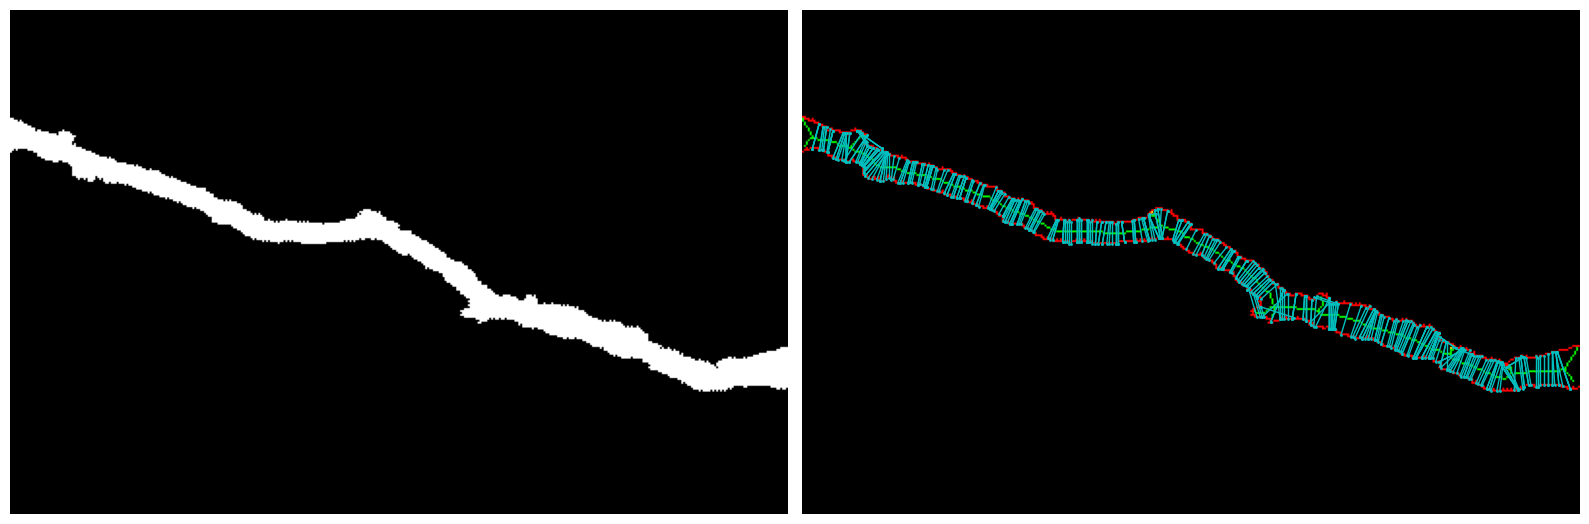

In [5]:
import numpy as np
from skimage import io
from skimage.morphology import medial_axis, skeletonize
from skimage import measure
from skimage import data
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from PIL import Image


def show_2dpoints(pointcluster,s=None,quivers=None,qscale=1):
    # pointcluster should be a list of numpy ndarray
    # This functions would show a list of pint cloud in different colors
    n = len(pointcluster)
    nmax = n
    if quivers is not None:
        nq = len(quivers)
        nmax = max(n,nq)
    
    colors = ['r','g','b','c','m','y','k','tomato','gold']
    if nmax < 10:
        colors = np.array(colors[0:nmax])
    else: 
        colors = np.random.rand(nmax,3)

    fig = plt.figure(num=1)
    ax = fig.add_subplot(1,1,1)

    if s is None:
        s = np.ones(n)*2

    for i in range(n):
        ax.scatter(pointcluster[i][:,0],pointcluster[i][:,1],s=s[i],c=[colors[i]],alpha=0.6)

    if quivers is not None:
        for i in range(nq):
            ax.quiver(quivers[i][:,0],quivers[i][:,1],quivers[i][:,2],quivers[i][:,3],color=[colors[i]],scale=qscale)

    plt.show()


def SVD(points):
    # 二维，三维均适用
    # 二维直线，三维平面
    pts = points.copy()
    # 奇异值分解
    c = np.mean(pts, axis=0)
    A = pts - c # shift the points
    A = A.T #3*n
    u, s, vh = np.linalg.svd(A, full_matrices=False, compute_uv=True) # A=u*s*vh
    normal = u[:,-1]

    # 法向量归一化
    nlen = np.sqrt(np.dot(normal,normal))
    normal = normal / nlen
    # normal 是主方向的方向向量 与PCA最小特征值对应的特征向量是垂直关系
    # u 每一列是一个方向
    # s 是对应的特征值
    # c >>> 点的中心
    # normal >>> 拟合的方向向量
    return u,s,c,normal


def calcu_dis_from_ctrlpts(ctrlpts):
    if ctrlpts.shape[1]==4:
        return np.sqrt(np.sum((ctrlpts[:,0:2]-ctrlpts[:,2:4])**2,axis=1))
    else:
        return np.sqrt(np.sum((ctrlpts[:,[0,2]]-ctrlpts[:,[3,5]])**2,axis=1))


def estimate_normal_for_pos(pos,points,n):
    """
    计算pos处的法向量.
    
    Input：
    ------
    pos: nx2 ndarray 需要计算法向量的位置.
    points: 骨架线的点集
    n: 用到的近邻点的个数
    
    Output：
    ------
    normals: nx2 ndarray 在pos位置处的法向量.
    """
    
    # estimate normal vectors at a given point
    pts = np.copy(points)
    tree = KDTree(pts, leaf_size=2)
    idx = tree.query(pos, k=n, return_distance=False, dualtree=False, breadth_first=False)
    #pts = np.concatenate((np.concatenate((pts[0].reshape(1,-1),pts),axis=0),pts[-1].reshape(1,-1)),axis=0)
    normals = []
    for i in range(0,pos.shape[0]):
        pts_for_normals = pts[idx[i,:],:]
        _,_,_,normal = SVD(pts_for_normals)
        normals.append(normal)
    normals = np.array(normals)
    return normals


def estimate_normals(points,n):
    """
    计算points表示的曲线上的每一个点法向量.
    等同于 estimate_normal_for_pos(points,points,n)

    Input：
    ------
    points: nx2 ndarray 曲线点集.
    n: 用到的近邻点的个数
    
    Output：
    ------
    normals: nx2 ndarray 在points曲线上的每一处的法向量.
    """
    
    pts = np.copy(points)
    tree = KDTree(pts, leaf_size=2)
    idx = tree.query(pts, k=n, return_distance=False, dualtree=False, breadth_first=False)
    #pts = np.concatenate((np.concatenate((pts[0].reshape(1,-1),pts),axis=0),pts[-1].reshape(1,-1)),axis=0)
    normals = []
    for i in range(0,pts.shape[0]):
        pts_for_normals = pts[idx[i,:],:]
        _,_,_,normal = SVD(pts_for_normals)
        normals.append(normal)
    normals = np.array(normals)
    return normals

def get_crack_ctrlpts(centers,normals,bpoints,hband=5,vband=2,est_width=0):
    # main algorithm to obtain crack width
    cpoints = np.copy(centers)
    cnormals = np.copy(normals)

    xmatrix = np.array([[0,1],[-1,0]])
    cnormalsx = np.dot(xmatrix,cnormals.T).T # the normal of x axis
    N = cpoints.shape[0]

    interp_segm = []
    widths = []
    for i in range(N):
        try:
            ny = cnormals[i]
            nx = cnormalsx[i]
            tform = np.array([nx,ny])
            bpoints_loc = np.dot(tform,bpoints.T).T
            cpoints_loc = np.dot(tform,cpoints.T).T
            ci = cpoints_loc[i]

            bl_ind = (bpoints_loc[:,0]-(ci[0]-hband))*(bpoints_loc[:,0]-ci[0])<0
            br_ind = (bpoints_loc[:,0]-ci[0])*(bpoints_loc[:,0]-(ci[0]+hband))<=0
            bl = bpoints_loc[bl_ind] # left points
            br = bpoints_loc[br_ind] # right points

            if est_width>0:
                # 下面的数值 est_width 是预估计的裂缝宽度
                half_est_width = est_width / 2
                blt = bl[(bl[:,1]-(ci[1]+half_est_width))*(bl[:,1]-ci[1])<0]
                blb = bl[(bl[:,1]-(ci[1]-half_est_width))*(bl[:,1]-ci[1])<0]
                brt = br[(br[:,1]-(ci[1]+half_est_width))*(br[:,1]-ci[1])<0]
                brb = br[(br[:,1]-(ci[1]-half_est_width))*(br[:,1]-ci[1])<0]
            else:
                blt = bl[bl[:,1]>np.mean(bl[:,1])]
                if np.ptp(blt[:,1])>vband:
                    blt = blt[blt[:,1]>np.mean(blt[:,1])]

                blb = bl[bl[:,1]<np.mean(bl[:,1])]
                if np.ptp(blb[:,1])>vband:
                    blb = blb[blb[:,1]<np.mean(blb[:,1])]

                brt = br[br[:,1]>np.mean(br[:,1])]
                if np.ptp(brt[:,1])>vband:
                    brt = brt[brt[:,1]>np.mean(brt[:,1])]

                brb = br[br[:,1]<np.mean(br[:,1])]
                if np.ptp(brb[:,1])>vband:
                    brb = brb[brb[:,1]<np.mean(brb[:,1])]

                # blt = bl[bl[:,1]>np.mean(bl[:,1])]
                # if np.ptp(blt[:,1])>vband:
                #    blt = blt[blt[:,1]<ci[1]+50]
                #    #blt = blt[blt[:,1]>np.mean(blt[:,1])] （外侧）
                #    #blt = blt[blt[:,1]<(np.max(blt[:,1])-0.5*np.ptp(blt[:,1]))] （内侧）

                # blb = bl[bl[:,1]<np.mean(bl[:,1])]
                # if np.ptp(blb[:,1])>vband:
                #    blb = blb[blb[:,1]>ci[1]-50]
                #    #blb = blb[blb[:,1]<np.mean(blb[:,1])]
                #    #blb = blb[blb[:,1]>(np.min(blb[:,1])+0.5*np.ptp(blb[:,1]))]

                # brt = br[br[:,1]>np.mean(br[:,1])]
                # if np.ptp(brt[:,1])>vband:
                #    brt = brt[brt[:,1]<ci[1]+50]
                #    #brt = brt[brt[:,1]>np.mean(brt[:,1])]
                #    #brt = brt[brt[:,1]<(np.max(brt[:,1])-0.5*np.ptp(brt[:,1]))]

                # brb = br[br[:,1]<np.mean(br[:,1])]
                # if np.ptp(brb[:,1])>vband:
                #    brb = brb[brb[:,1]>ci[1]-50]
                #    # brb = brb[brb[:,1]<np.mean(brb[:,1])]
                #    # brb = brb[brb[:,1]>(np.min(brb[:,1])+0.5*np.ptp(brb[:,1]))]

            #bh = np.vstack((bl,br))
            #bmax = np.max(bh[:,1])
            #bmin = np.min(bh[:,1])

            #blt = bl[bl[:,1]>bmax-vband] # left top points
            #blb = bl[bl[:,1]<bmin+vband] # left bottom points

            #brt = br[br[:,1]>bmax-vband] # right top points
            #brb = br[br[:,1]<bmin+vband] # right bottom points


            t1 = blt[np.argsort(blt[:,0])[-1]]
            t2 = brt[np.argsort(brt[:,0])[0]]

            b1 = blb[np.argsort(blb[:,0])[-1]]
            b2 = brb[np.argsort(brb[:,0])[0]]


            interp1 = (ci[0]-t1[0])*((t2[1]-t1[1])/(t2[0]-t1[0]))+t1[1]
            interp2 = (ci[0]-b1[0])*((b2[1]-b1[1])/(b2[0]-b1[0]))+b1[1]

            if interp1-ci[1]>0 and interp2-ci[1]<0:
                widths.append([i,interp1-ci[1],interp2-ci[1]])

                interps = np.array([[ci[0],interp1],[ci[0],interp2]])

                interps_rec = np.dot(np.linalg.inv(tform),interps.T).T

                #show_2dpoints([bpointsxl_loc1,bpointsxl_loc2,bpointsxr_loc1,bpointsxr_loc2,np.array([ptsl_1,ptsl_2]),np.array([ptsr_1,ptsr_2]),interps,ci.reshape(1,-1)],s=[1,1,1,1,20,20,20,20])
                interps_rec = interps_rec.reshape(1,-1)[0,:]
                interp_segm.append(interps_rec)
        except:
            print("the %d-th was wrong" % i)
            continue
    interp_segm = np.array(interp_segm)
    widths = np.array(widths)
    # check
    # show_2dpoints([np.array([[ci[0],interp1],[ci[0],interp2]]),np.array([t1,t2,b1,b2]),cpoints_loc,bl,br],[10,20,15,2,2])
    return interp_segm, widths


# path = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/projection/CFD_044.jpg'
path = '/home/ubunto/图片/2025-06-13_15-51.png'


# image = io.imread(path, as_gray=True)
image_pil = Image.open(path).convert('1')
image = np.array(image_pil)
# image中不为1的地方为背景，为1的地方为前景
image[image!= 1] = 0
image[image == 1] = 255
print(image.shape)
iw,ih = image.shape

blobs  = np.copy(image)
# blobs[blobs<128] = 0
# blobs[blobs>128] = 1

blobs = blobs.astype(np.uint8)
# Generate the data
#blobs = data.binary_blobs(200, blob_size_fraction=.2,
                          #volume_fraction=.35, seed=1)
# using scikit-image
## Compute the medial axis (skeleton) and the distance transform
#skel, distance = medial_axis(blobs, return_distance=True)
## Distance to the background for pixels of the skeleton
#dist_on_skel = distance * skel

# Compare with other skeletonization algorithms
print(blobs)
skeleton = skeletonize(blobs)
#skeleton_lee = skeletonize(blobs, method='lee')
x, y = np.where(skeleton>0)
centers = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))

normals = estimate_normals(centers, 9) # 这个用于估计法向量的KNN

# search contours of the crack
contours = measure.find_contours(blobs, 0.8)
print(contours[0].shape, contours[1].shape) 
bl = contours[0]
br = contours[1]

bpoints = np.vstack((bl,br))

#interp_segm, widths = get_crack_ctrlpts(centers,normals,bpoints,hband=2,vband=2)


bpixel = np.zeros((iw,ih,3),dtype=np.uint8)
bpoints = bpoints.astype(np.int64)
bpixel[bpoints[:,0],bpoints[:,1],0] = 255

skeleton_pixel = np.zeros((iw,ih,3),dtype=np.uint8)
skeleton_pixel[skeleton,1] = 255

bpixel_and_skeleton = np.copy(bpixel)
bpixel_and_skeleton[skeleton,1] = 255


fig, axes = plt.subplots(1,2, figsize=(16, 16))
ax = axes.ravel()

ax[0].imshow(blobs, cmap=plt.cm.gray)
ax[0].axis('off')


ax[1].imshow(bpixel_and_skeleton)
#for contour in contours:
#    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

#for i in range(interp_segm.shape[0]):
#    ax[1].plot([interp_segm[i,1],interp_segm[i,3]],[interp_segm[i,0],interp_segm[i,2]],'-b')

#ax[1].set_title('medial_axis')
ax[1].axis('off')



interps, widths = get_crack_ctrlpts(centers, normals, bpoints, hband=2, vband=2, est_width=30)
print('interps.shape, widths.shape', interps.shape, widths.shape)

# interps_show = interps[np.random.choice(interps.shape[0], 120, replace=False),:] # 由于太多，这里随机采样120个测量位置，进行显示
interps_show = interps[np.random.choice(interps.shape[0], interps.shape[0]),:] # 由于太多，这里随机采样120个测量位置，进行显示
for i in range(interps_show.shape[0]):
    ax[1].plot([interps_show[i,1],interps_show[i,3]],[interps_show[i,0],interps_show[i,2]],c='c', ls='-', lw=1, marker='o',ms=1,mec='c',mfc='c')



## ================ small window ==================
#pos = np.array([191, 291]).reshape(1,-1) # input (x,y) where need to calculate crack width
## pos = np.array([142, 178]).reshape(1,-1)

#posn = estimate_normal_for_pos(pos,centers,3)

#interps, widths2 = get_crack_ctrlpts(pos,posn,bpoints,hband=1.5,vband=2)


#sx = pos[0,0] - 20
#sy = pos[0,1] - 20

#ax[2].imshow(bpixel_and_skeleton)

#for i in range(interps.shape[0]):
#    ax[2].plot([interps[i,1],interps[i,3]],[interps[i,0],interps[i,2]],c='c',ls='-',lw=5,marker='o',ms=8,mec='c',mfc='c')

#ax[2].set_ylim(sx,sx+40)
#ax[2].set_xlim(sy,sy+40)

##ax[2].set_title('skeletonize')
#ax[2].axis('off')

#print(interps)

fig.tight_layout()

plt.show()



In [8]:
interps_show[0]

array([61.10651268, 13.89348732, 73.        , 12.09036473])

(260, 401)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [0 1]
(665, 2) (662, 2)
the 0-th was wrong
the 1-th was wrong
the 2-th was wrong
the 3-th was wrong
the 4-th was wrong
the 5-th was wrong
the 6-th was wrong
the 7-th was wrong
the 8-th was wrong
the 9-th was wrong
the 13-th was wrong
the 14-th was wrong
the 19-th was wrong
the 27-th was wrong
the 28-th was wrong
the 32-th was wrong
the 33-th was wrong
the 35-th was wrong
the 36-th was wrong
the 137-th was wrong
the 140-th was wrong
the 141-th was wrong
the 144-th was wrong
the 147-th was wrong
the 150-th was wrong
the 278-th was wrong
the 279-th was wrong
the 280-th was wrong
the 281-th was wrong
the 283-th was wrong
the 284-th was wrong
the 285-th was wrong
the 298-th was wrong
the 299-th was wrong
the 300-th was wrong
the 313-th was wrong
the 321-th was wrong
the 324-th was wrong
the 335-th was wrong
the 384-th was wrong
the 386-th was wrong
the 392-th wa

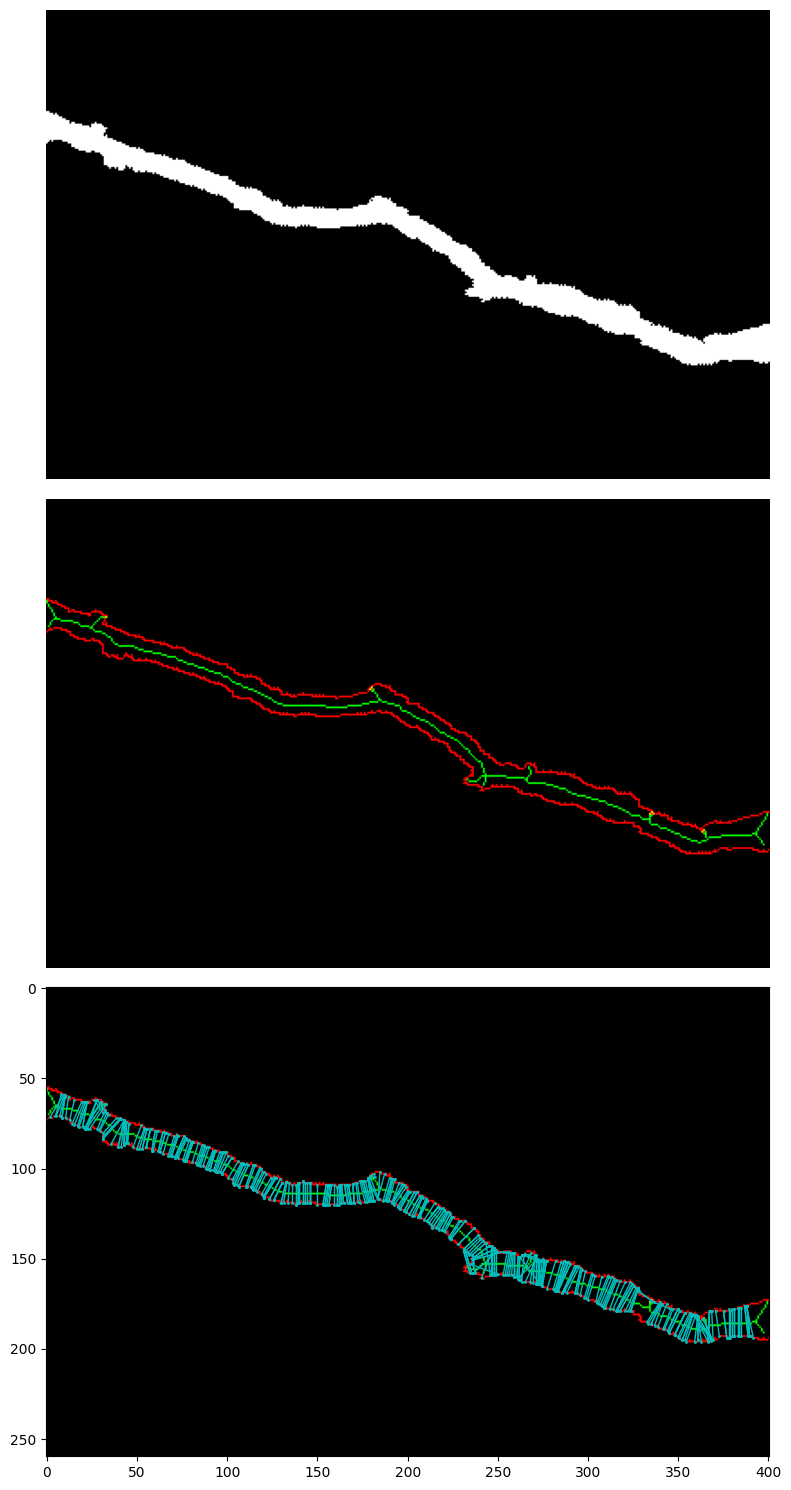

In [27]:
import numpy as np
from skimage import io
from skimage.morphology import medial_axis, skeletonize
from skimage import measure
from skimage import data
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from PIL import Image


def show_2dpoints(pointcluster,s=None,quivers=None,qscale=1):
    # pointcluster should be a list of numpy ndarray
    # This functions would show a list of pint cloud in different colors
    n = len(pointcluster)
    nmax = n
    if quivers is not None:
        nq = len(quivers)
        nmax = max(n,nq)
    
    colors = ['r','g','b','c','m','y','k','tomato','gold']
    if nmax < 10:
        colors = np.array(colors[0:nmax])
    else: 
        colors = np.random.rand(nmax,3)

    fig = plt.figure(num=1)
    ax = fig.add_subplot(1,1,1)

    if s is None:
        s = np.ones(n)*2

    for i in range(n):
        ax.scatter(pointcluster[i][:,0],pointcluster[i][:,1],s=s[i],c=[colors[i]],alpha=0.6)

    if quivers is not None:
        for i in range(nq):
            ax.quiver(quivers[i][:,0],quivers[i][:,1],quivers[i][:,2],quivers[i][:,3],color=[colors[i]],scale=qscale)

    plt.show()


def SVD(points):
    # 二维，三维均适用
    # 二维直线，三维平面
    pts = points.copy()
    # 奇异值分解
    c = np.mean(pts, axis=0)
    A = pts - c # shift the points
    A = A.T #3*n
    u, s, vh = np.linalg.svd(A, full_matrices=False, compute_uv=True) # A=u*s*vh
    normal = u[:,-1]

    # 法向量归一化
    nlen = np.sqrt(np.dot(normal,normal))
    normal = normal / nlen
    # normal 是主方向的方向向量 与PCA最小特征值对应的特征向量是垂直关系
    # u 每一列是一个方向
    # s 是对应的特征值
    # c >>> 点的中心
    # normal >>> 拟合的方向向量
    return u,s,c,normal


def calcu_dis_from_ctrlpts(ctrlpts):
    if ctrlpts.shape[1]==4:
        return np.sqrt(np.sum((ctrlpts[:,0:2]-ctrlpts[:,2:4])**2,axis=1))
    else:
        return np.sqrt(np.sum((ctrlpts[:,[0,2]]-ctrlpts[:,[3,5]])**2,axis=1))


def estimate_normal_for_pos(pos,points,n):
    """
    计算pos处的法向量.
    
    Input：
    ------
    pos: nx2 ndarray 需要计算法向量的位置.
    points: 骨架线的点集
    n: 用到的近邻点的个数
    
    Output：
    ------
    normals: nx2 ndarray 在pos位置处的法向量.
    """
    
    # estimate normal vectors at a given point
    pts = np.copy(points)
    tree = KDTree(pts, leaf_size=2)
    idx = tree.query(pos, k=n, return_distance=False, dualtree=False, breadth_first=False)
    #pts = np.concatenate((np.concatenate((pts[0].reshape(1,-1),pts),axis=0),pts[-1].reshape(1,-1)),axis=0)
    normals = []
    for i in range(0,pos.shape[0]):
        pts_for_normals = pts[idx[i,:],:]
        _,_,_,normal = SVD(pts_for_normals)
        normals.append(normal)
    normals = np.array(normals)
    return normals


def estimate_normals(points,n):
    """
    计算points表示的曲线上的每一个点法向量.
    等同于 estimate_normal_for_pos(points,points,n)

    Input：
    ------
    points: nx2 ndarray 曲线点集.
    n: 用到的近邻点的个数
    
    Output：
    ------
    normals: nx2 ndarray 在points曲线上的每一处的法向量.
    """
    
    pts = np.copy(points)
    tree = KDTree(pts, leaf_size=2)
    idx = tree.query(pts, k=n, return_distance=False, dualtree=False, breadth_first=False)
    #pts = np.concatenate((np.concatenate((pts[0].reshape(1,-1),pts),axis=0),pts[-1].reshape(1,-1)),axis=0)
    normals = []
    for i in range(0,pts.shape[0]):
        pts_for_normals = pts[idx[i,:],:]
        _,_,_,normal = SVD(pts_for_normals)
        normals.append(normal)
    normals = np.array(normals)
    return normals

def get_crack_ctrlpts(centers,normals,bpoints,hband=5,vband=2,est_width=0):
    # main algorithm to obtain crack width
    cpoints = np.copy(centers)
    cnormals = np.copy(normals)

    xmatrix = np.array([[0,1],[-1,0]])  # 将一个二维向量逆时针旋转90度
    cnormalsx = np.dot(xmatrix,cnormals.T).T # the normal of x axis
    N = cpoints.shape[0]

    interp_segm = []
    widths = []
    for i in range(N):
        try:
            ny = cnormals[i]
            nx = cnormalsx[i]
            tform = np.array([nx,ny])
            bpoints_loc = np.dot(tform,bpoints.T).T
            cpoints_loc = np.dot(tform,cpoints.T).T
            ci = cpoints_loc[i]

            bl_ind = (bpoints_loc[:,0]-(ci[0]-hband))*(bpoints_loc[:,0]-ci[0])<0 # 确定 bpoints_loc 中哪些点位于中心点 ci 的左侧，并且在水平方向上距离 ci 不超过 hband 的范围
            br_ind = (bpoints_loc[:,0]-ci[0])*(bpoints_loc[:,0]-(ci[0]+hband))<=0
            bl = bpoints_loc[bl_ind] # left points
            br = bpoints_loc[br_ind] # right points

            if est_width>0:
                # 下面的数值 est_width 是预估计的裂缝宽度
                half_est_width = est_width / 2
                blt = bl[(bl[:,1]-(ci[1]+half_est_width))*(bl[:,1]-ci[1])<0]
                blb = bl[(bl[:,1]-(ci[1]-half_est_width))*(bl[:,1]-ci[1])<0]
                brt = br[(br[:,1]-(ci[1]+half_est_width))*(br[:,1]-ci[1])<0]
                brb = br[(br[:,1]-(ci[1]-half_est_width))*(br[:,1]-ci[1])<0]
            else:
                blt = bl[bl[:,1]>np.mean(bl[:,1])]
                if np.ptp(blt[:,1])>vband:
                    blt = blt[blt[:,1]>np.mean(blt[:,1])]

                blb = bl[bl[:,1]<np.mean(bl[:,1])]
                if np.ptp(blb[:,1])>vband:
                    blb = blb[blb[:,1]<np.mean(blb[:,1])]

                brt = br[br[:,1]>np.mean(br[:,1])]
                if np.ptp(brt[:,1])>vband:
                    brt = brt[brt[:,1]>np.mean(brt[:,1])]

                brb = br[br[:,1]<np.mean(br[:,1])]
                if np.ptp(brb[:,1])>vband:
                    brb = brb[brb[:,1]<np.mean(brb[:,1])]

                # blt = bl[bl[:,1]>np.mean(bl[:,1])]
                # if np.ptp(blt[:,1])>vband:
                #    blt = blt[blt[:,1]<ci[1]+50]
                #    #blt = blt[blt[:,1]>np.mean(blt[:,1])] （外侧）
                #    #blt = blt[blt[:,1]<(np.max(blt[:,1])-0.5*np.ptp(blt[:,1]))] （内侧）

                # blb = bl[bl[:,1]<np.mean(bl[:,1])]
                # if np.ptp(blb[:,1])>vband:
                #    blb = blb[blb[:,1]>ci[1]-50]
                #    #blb = blb[blb[:,1]<np.mean(blb[:,1])]
                #    #blb = blb[blb[:,1]>(np.min(blb[:,1])+0.5*np.ptp(blb[:,1]))]

                # brt = br[br[:,1]>np.mean(br[:,1])]
                # if np.ptp(brt[:,1])>vband:
                #    brt = brt[brt[:,1]<ci[1]+50]
                #    #brt = brt[brt[:,1]>np.mean(brt[:,1])]
                #    #brt = brt[brt[:,1]<(np.max(brt[:,1])-0.5*np.ptp(brt[:,1]))]

                # brb = br[br[:,1]<np.mean(br[:,1])]
                # if np.ptp(brb[:,1])>vband:
                #    brb = brb[brb[:,1]>ci[1]-50]
                #    # brb = brb[brb[:,1]<np.mean(brb[:,1])]
                #    # brb = brb[brb[:,1]>(np.min(brb[:,1])+0.5*np.ptp(brb[:,1]))]

            #bh = np.vstack((bl,br))
            #bmax = np.max(bh[:,1])
            #bmin = np.min(bh[:,1])

            #blt = bl[bl[:,1]>bmax-vband] # left top points
            #blb = bl[bl[:,1]<bmin+vband] # left bottom points

            #brt = br[br[:,1]>bmax-vband] # right top points
            #brb = br[br[:,1]<bmin+vband] # right bottom points


            t1 = blt[np.argsort(blt[:,0])[-1]]
            t2 = brt[np.argsort(brt[:,0])[0]]

            b1 = blb[np.argsort(blb[:,0])[-1]]
            b2 = brb[np.argsort(brb[:,0])[0]]


            interp1 = (ci[0]-t1[0])*((t2[1]-t1[1])/(t2[0]-t1[0]))+t1[1]
            interp2 = (ci[0]-b1[0])*((b2[1]-b1[1])/(b2[0]-b1[0]))+b1[1]

            if interp1-ci[1]>0 and interp2-ci[1]<0:
                widths.append([i,interp1-ci[1],interp2-ci[1]])

                interps = np.array([[ci[0],interp1],[ci[0],interp2]])

                interps_rec = np.dot(np.linalg.inv(tform),interps.T).T

                #show_2dpoints([bpointsxl_loc1,bpointsxl_loc2,bpointsxr_loc1,bpointsxr_loc2,np.array([ptsl_1,ptsl_2]),np.array([ptsr_1,ptsr_2]),interps,ci.reshape(1,-1)],s=[1,1,1,1,20,20,20,20])
                interps_rec = interps_rec.reshape(1,-1)[0,:]
                interp_segm.append(interps_rec)
        except:
            print("the %d-th was wrong" % i)
            continue
    interp_segm = np.array(interp_segm)
    widths = np.array(widths)
    # check
    # show_2dpoints([np.array([[ci[0],interp1],[ci[0],interp2]]),np.array([t1,t2,b1,b2]),cpoints_loc,bl,br],[10,20,15,2,2])
    return interp_segm, widths

if __name__ == '__main__':
    # path = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/projection/CFD_044.jpg'
    path = '/home/ubunto/图片/2025-06-13_15-51.png'

    # image = io.imread(path, as_gray=True)
    image_pil = Image.open(path).convert('1')
    image = np.array(image_pil)
    # image中不为1的地方为背景，为1的地方为前景
    image[image!= 1] = 0
    image[image == 1] = 255
    print(image.shape)
    iw,ih = image.shape

    blobs  = np.copy(image)
    # blobs[blobs<128] = 0
    # blobs[blobs>128] = 1

    blobs = blobs.astype(np.uint8)
    # Generate the data
    #blobs = data.binary_blobs(200, blob_size_fraction=.2,
                            #volume_fraction=.35, seed=1)
    # using scikit-image
    ## Compute the medial axis (skeleton) and the distance transform
    #skel, distance = medial_axis(blobs, return_distance=True)
    ## Distance to the background for pixels of the skeleton
    #dist_on_skel = distance * skel

    # Compare with other skeletonization algorithms
    print(blobs, np.unique(blobs))
    skeleton = skeletonize(blobs)
    #skeleton_lee = skeletonize(blobs, method='lee')
    x, y = np.where(skeleton>0)
    centers = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))

    normals = estimate_normals(centers, 9) # 这个用于估计法向量的KNN

    # search contours of the crack
    contours = measure.find_contours(blobs, 0.8)
    print(contours[0].shape, contours[1].shape) 
    bl = contours[0]
    br = contours[1]

    bpoints = np.vstack((bl,br))

    #interp_segm, widths = get_crack_ctrlpts(centers,normals,bpoints,hband=2,vband=2)


    bpixel = np.zeros((iw,ih,3),dtype=np.uint8)
    bpoints = bpoints.astype(np.int64)
    bpixel[bpoints[:,0],bpoints[:,1],0] = 255 # 将 bpixel 图像中特定像素的红色通道（通道0）设置为255

    skeleton_pixel = np.zeros((iw,ih,3),dtype=np.uint8)
    skeleton_pixel[skeleton,1] = 255 # 将 skeleton_pixel 图像中特定像素的绿色通道（通道1）设置为255

    bpixel_and_skeleton = np.copy(bpixel)
    bpixel_and_skeleton[skeleton,1] = 255  # 将 skeleton_pixel 图像中特定像素的绿色通道（通道1）设置为255


    fig, axes = plt.subplots(3,1, figsize=(60, 15))
    ax = axes.ravel()

    ax[0].imshow(blobs, cmap=plt.cm.gray)
    ax[0].axis('off')


    ax[1].imshow(bpixel_and_skeleton)
    #for contour in contours:
    #    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

    #for i in range(interp_segm.shape[0]):
    #    ax[1].plot([interp_segm[i,1],interp_segm[i,3]],[interp_segm[i,0],interp_segm[i,2]],'-b')

    #ax[1].set_title('medial_axis')
    ax[1].axis('off')

    ax[2].imshow(bpixel_and_skeleton)

    interps, widths = get_crack_ctrlpts(centers, normals, bpoints, hband=2, vband=2, est_width=30)
    print('interps.shape, widths.shape', interps.shape, widths.shape)

    # interps_show = interps[np.random.choice(interps.shape[0], 120, replace=False),:] # 由于太多，这里随机采样120个测量位置，进行显示
    interps_show = interps[np.random.choice(interps.shape[0], interps.shape[0]),:] # 由于太多，这里随机采样120个测量位置，进行显示
    for i in range(interps_show.shape[0]):
        ax[2].plot([interps_show[i,1],interps_show[i,3]],[interps_show[i,0],interps_show[i,2]],c='c', ls='-', lw=1, marker='o',ms=1,mec='c',mfc='c')



    ## ================ small window ==================
    #pos = np.array([191, 291]).reshape(1,-1) # input (x,y) where need to calculate crack width
    ## pos = np.array([142, 178]).reshape(1,-1)

    #posn = estimate_normal_for_pos(pos,centers,3)

    #interps, widths2 = get_crack_ctrlpts(pos,posn,bpoints,hband=1.5,vband=2)


    #sx = pos[0,0] - 20
    #sy = pos[0,1] - 20

    #ax[2].imshow(bpixel_and_skeleton)

    #for i in range(interps.shape[0]):
    #    ax[2].plot([interps[i,1],interps[i,3]],[interps[i,0],interps[i,2]],c='c',ls='-',lw=5,marker='o',ms=8,mec='c',mfc='c')

    #ax[2].set_ylim(sx,sx+40)
    #ax[2].set_xlim(sy,sy+40)

    ##ax[2].set_title('skeletonize')
    #ax[2].axis('off')

    #print(interps)

    fig.tight_layout()

    plt.show()
    fig.savefig(f'output_skeleton_{path.split("/")[-1].split(".")[0]}.png')



In [20]:
skeleton_pixel_demo = np.zeros((iw,ih,3),dtype=np.uint8)
skeleton.shape, np.unique(skeleton)


((260, 401), array([False,  True]))

In [20]:
import numpy as np

def calculate_normal(tangent):
    """计算单位法线向量（顺时针旋转90度）"""
    tangent = np.array(tangent)
    tangent_normalized = tangent / np.linalg.norm(tangent)
    normal = np.array([-tangent_normalized[1], tangent_normalized[0]])
    return normal

def line_segment_intersection(ray_start, ray_dir, seg_start, seg_end):
    """检测射线与线段交点"""
    # 将射线和线段转换为参数方程
    seg_vec = seg_end - seg_start
    ray_vec = ray_dir
    
    # 构造线性方程组
    A = np.column_stack([seg_vec, -ray_vec])
    b = ray_start - seg_start
    
    try:
        t, d = np.linalg.solve(A, b)
        if t >= 0 and t <= 1 and d >= 0:
            intersection = seg_start + t * seg_vec
            return intersection
        else:
            return None
    except np.linalg.LinAlgError:
        return None  # 平行或共线无解

# 示例数据
skeleton_points = np.array([[0, 0], [1, 1], [2, 2], [3, 3]])  # 骨架线
upper_boundary = np.array([[-1, 1], [0, 2], [1, 3], [2, 4]])  # 上边界线
lower_boundary = np.array([[1, -1], [2, 0], [3, 1], [4, 2]])  # 下边界线

# 存储交点
upper_intersections = []
lower_intersections = []

for i in range(1, len(skeleton_points) - 1):  # 跳过首尾点
    # 计算当前骨架点的切线（前后差分）
    prev_point = skeleton_points[i-1]
    next_point = skeleton_points[i+1]
    tangent = next_point - prev_point
    normal = calculate_normal(tangent)
    
    # 沿法线正方向检测上边界交点
    ray_start = skeleton_points[i]
    for j in range(len(upper_boundary) - 1):
        seg_start = upper_boundary[j]
        seg_end = upper_boundary[j+1]
        intersection = line_segment_intersection(ray_start, normal, seg_start, seg_end)
        if intersection is not None:
            upper_intersections.append(intersection)
            break
    
    # 沿法线反方向检测下边界交点
    reverse_normal = -normal
    for j in range(len(lower_boundary) - 1) :
        seg_start = lower_boundary[j]
        seg_end = lower_boundary[j+1]
        intersection = line_segment_intersection(ray_start, reverse_normal, seg_start, seg_end)
        if intersection is not None:
            lower_intersections.append(intersection)
            break

# 打印结果
print("Upper boundary intersections:", upper_intersections)
print("Lower boundary intersections:", lower_intersections)

Upper boundary intersections: [array([0., 2.]), array([1., 3.])]
Lower boundary intersections: [array([2., 0.]), array([3., 1.])]


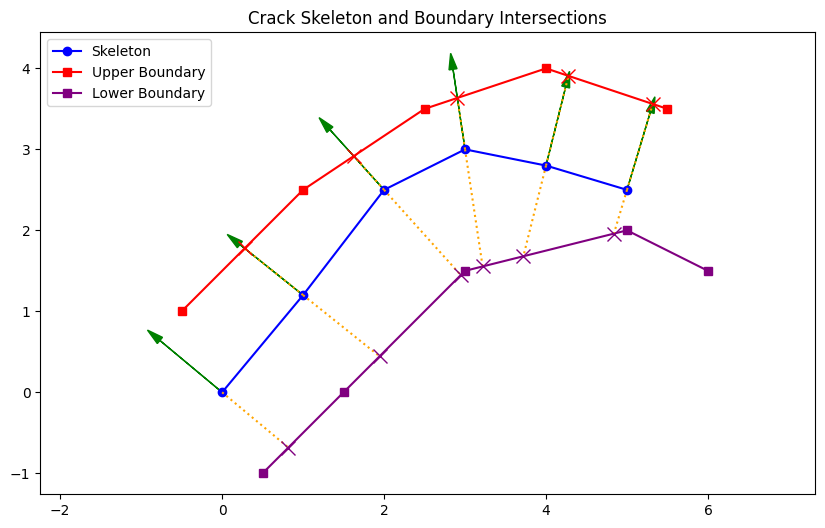

骨架点与上边界交点坐标：
Skeleton Point 0 (0.0, 0.0) -> Upper: None
Skeleton Point 1 (1.0, 1.2) -> Upper: [0.27777778 1.77777778]
Skeleton Point 2 (2.0, 2.5) -> Upper: [1.625      2.91666667]
Skeleton Point 3 (3.0, 3.0) -> Upper: [2.9047619  3.63492063]
Skeleton Point 4 (4.0, 2.8) -> Upper: [4.27692308 3.90769231]
Skeleton Point 5 (5.0, 2.5) -> Upper: [5.31818182 3.56060606]

骨架点与下边界交点坐标：
Skeleton Point 0 (0.0, 0.0) -> Lower: [ 0.81818182 -0.68181818]
Skeleton Point 1 (1.0, 1.2) -> Lower: [1.94444444 0.44444444]
Skeleton Point 2 (2.0, 2.5) -> Lower: [2.94736842 1.44736842]
Skeleton Point 3 (3.0, 3.0) -> Lower: [3.21686747 1.55421687]
Skeleton Point 4 (4.0, 2.8) -> Lower: [3.72 1.68]
Skeleton Point 5 (5.0, 2.5) -> Lower: [4.83783784 1.95945946]


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def compute_tangent_and_normal(points):
    """计算骨架点集的切线和单位法线方向（确保法线方向一致）"""
    tangents = []
    normals = []
    n = len(points)
    for i in range(n):
        if i == 0:
            # 起始点：用下一个点计算切线
            tangent = points[i+1] - points[i]
        elif i == n-1:
            # 终止点：用前一个点计算切线
            tangent = points[i] - points[i-1]
        else:
            # 中间点：前后差分平均
            tangent = (points[i+1] - points[i-1])
        
        # 归一化切线
        tangent_norm = np.linalg.norm(tangent)
        if tangent_norm < 1e-6:  # 避免零向量
            tangent = np.array([1.0, 0.0])
            tangent_norm = 1.0
        tangent = tangent / tangent_norm
        
        # 计算法线方向（左手法则，可以根据需要调整为右手）
        normal = np.array([-tangent[1], tangent[0]])
        tangents.append(tangent)
        normals.append(normal)
    
    # 确保法线方向一致：例如，所有法线指向同一侧（假设边界在上方）
    # 方法：取第一个点的法线与到边界的方向是否一致（此处假设手动调整）
    if np.dot(normals[0], (upper_boundary[0] - skeleton_points[0])) < 0:
        normals = [-n for n in normals]
    
    return np.array(tangents), np.array(normals)

def ray_segment_intersection(ray_origin, ray_dir, seg_start, seg_end):
    """求解射线与线段的交点（2D平面）"""
    # 射线方向向量
    ray_dir = ray_dir / np.linalg.norm(ray_dir)
    # 线段向量
    seg_vec = seg_end - seg_start
    # 构造方程：ray_origin + t*ray_dir = seg_start + u*seg_vec (0 <= u <= 1)
    A = np.array([ray_dir, -seg_vec]).T
    b = seg_start - ray_origin
    try:
        t, u = np.linalg.solve(A, b)
        if u >= 0 and u <= 1 and t >= 0:
            intersection = ray_origin + t * ray_dir
            return intersection
        else:
            return None
    except np.linalg.LinAlgError:
        return None  # 无解或无穷解

# ---------------------------- 示例数据 ----------------------------
# 骨架点（假设为2D坐标）
skeleton_points = np.array([
    [0.0, 0.0],
    [1.0, 1.2],
    [2.0, 2.5],
    [3.0, 3.0],
    [4.0, 2.8],
    [5.0, 2.5],
])

# 上边界线（折线段）
upper_boundary = np.array([
    [-0.5, 1.0],
    [1.0, 2.5],
    [2.5, 3.5],
    [4.0, 4.0],
    [5.5, 3.5],
])

# 下边界线（折线段）
lower_boundary = np.array([
    [0.5, -1.0],
    [1.5, 0.0],
    [3.0, 1.5],
    [5.0, 2.0],
    [6.0, 1.5]
])

# -------------------------- 计算法线 --------------------------
tangents, normals = compute_tangent_and_normal(skeleton_points)

# -------------------------- 查找交点 --------------------------
upper_intersects = []
lower_intersects = []

# 遍历每个骨架点
for i, (point, normal) in enumerate(zip(skeleton_points, normals)):
    # ------------------------------------------
    # 查找与上边界的交点（沿法线正方向）
    # ------------------------------------------
    upper_intersect = None
    for j in range(len(upper_boundary)-1):
        seg_start = upper_boundary[j]
        seg_end = upper_boundary[j+1]
        intersection = ray_segment_intersection(
            ray_origin=point,
            ray_dir=normal * 10.0,  # 扩大法线长度确保与线段相交
            seg_start=seg_start,
            seg_end=seg_end
        )
        if intersection is not None:
            upper_intersect = intersection
            break  # 取第一个交点
    
    # ------------------------------------------
    # 查找与下边界的交点（沿法线反方向）
    # ------------------------------------------
    lower_intersect = None
    for j in range(len(lower_boundary)-1):
        seg_start = lower_boundary[j]
        seg_end = lower_boundary[j+1]
        intersection = ray_segment_intersection(
            ray_origin=point,
            ray_dir=-normal * 10.0,  # 反向法线
            seg_start=seg_start,
            seg_end=seg_end
        )
        if intersection is not None:
            lower_intersect = intersection
            break
    
    # 记录结果（允许None）
    upper_intersects.append(upper_intersect)
    lower_intersects.append(lower_intersect)

# ------------------------ 可视化结果 ------------------------
plt.figure(figsize=(10, 6))

# 绘制骨架线和法线
plt.plot(skeleton_points[:,0], skeleton_points[:,1], 'o-', color='blue', label='Skeleton')
for point, normal in zip(skeleton_points, normals):
    plt.arrow(point[0], point[1], normal[0], normal[1], 
              head_width=0.1, head_length=0.2, fc='green', ec='green')

# 绘制上下边界线
plt.plot(upper_boundary[:,0], upper_boundary[:,1], 's-', color='red', label='Upper Boundary')
plt.plot(lower_boundary[:,0], lower_boundary[:,1], 's-', color='purple', label='Lower Boundary')

# 绘制交点
for up, low, sk in zip(upper_intersects, lower_intersects, skeleton_points):
    if up is not None:
        plt.plot([sk[0], up[0]], [sk[1], up[1]], ':', color='orange')
        plt.plot(up[0], up[1], 'x', color='red', markersize=10)
    if low is not None:
        plt.plot([sk[0], low[0]], [sk[1], low[1]], ':', color='orange')
        plt.plot(low[0], low[1], 'x', color='purple', markersize=10)

plt.axis('equal')
plt.legend()
plt.title("Crack Skeleton and Boundary Intersections")
plt.show()

# ------------------------ 结果输出 ------------------------
print("骨架点与上边界交点坐标：")
for i, (sk, pt) in enumerate(zip(skeleton_points, upper_intersects)):
    print(f"Skeleton Point {i} ({sk[0]:.1f}, {sk[1]:.1f}) -> Upper: {pt}")

print("\n骨架点与下边界交点坐标：")
for i, (sk, pt) in enumerate(zip(skeleton_points, lower_intersects)):
    print(f"Skeleton Point {i} ({sk[0]:.1f}, {sk[1]:.1f}) -> Lower: {pt}")